<a href="https://colab.research.google.com/github/Zeeshan-CR7/Skin-Cancer-Prediction-using-CNN/blob/main/Zeeshan_Mohiyuddin_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [10]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset='training', 
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset='validation', 
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

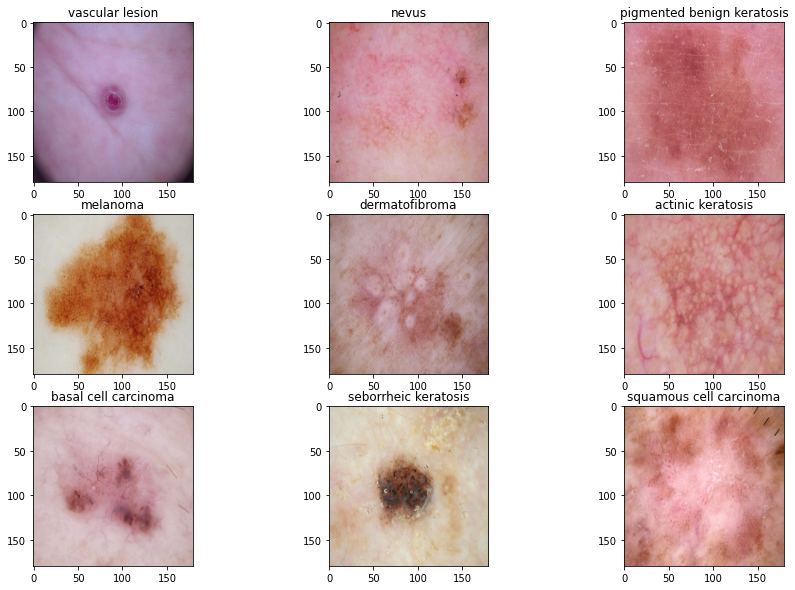

In [18]:
import matplotlib.pyplot as plt
x = []
ind = 0

plt.figure(figsize=[15,10])
for images, labels in train_ds.take(7):
    for i in range(9):
        l = class_names[labels[i]]
        if l not in x:
            ind += 1
            ax = plt.subplot(3, 3, ind)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(l)
            x.append(l)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(9))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [26]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 64)       

### Train the model

In [28]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 502s 2s/step - loss: 2.1503 - accuracy: 0.2126 - val_loss: 1.9293 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7955 - accuracy: 0.3493 - val_loss: 1.6225 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5520 - accuracy: 0.4492 - val_loss: 1.4972 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4596 - accuracy: 0.4872 - val_loss: 1.5217 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3672 - accuracy: 0.5290 - val_loss: 1.3962 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2756 - accuracy: 0.5379 - val_loss: 1.3148 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2259 - accuracy: 0.5614 - val_loss: 1.4446 - val_accuracy: 0.4922
Epoch 8/20
56

### Visualizing training results

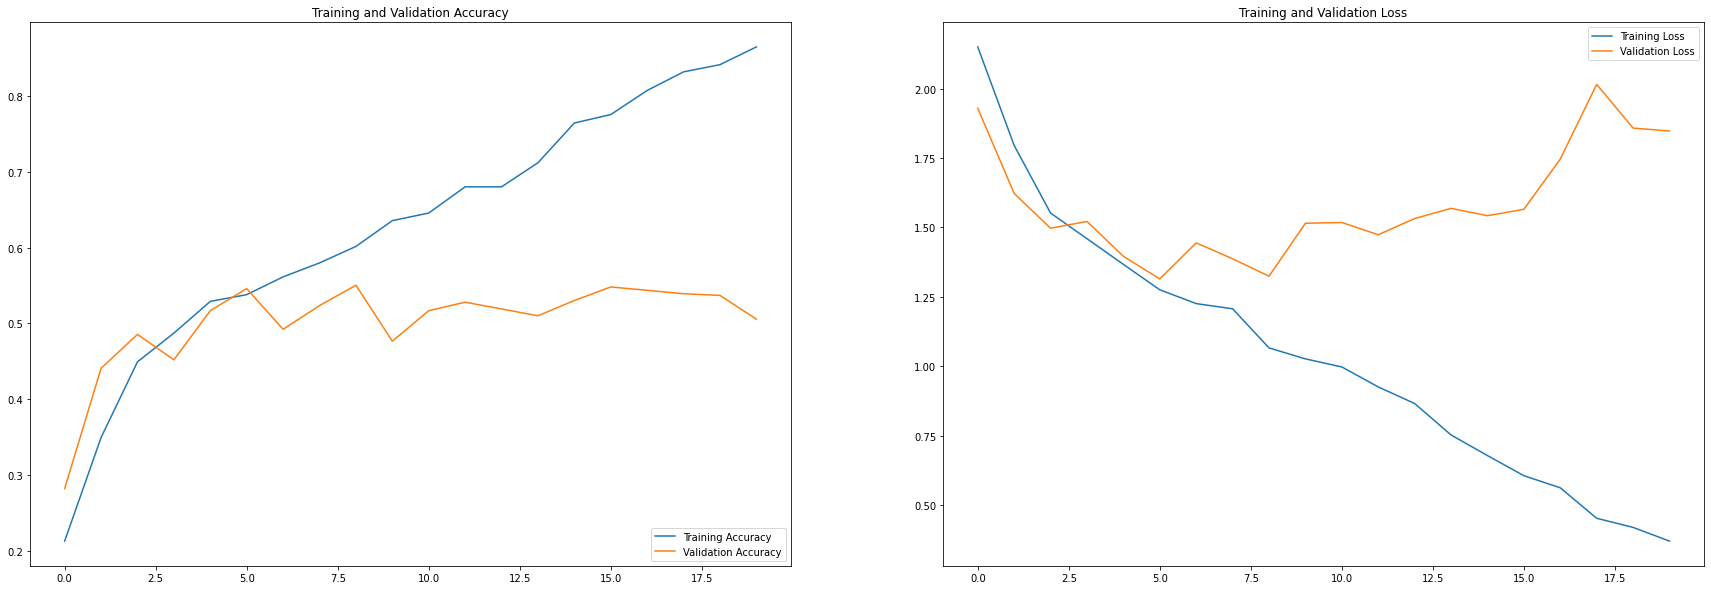

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### The model does train well over the training set, but fails to perfom well on the validation set. It is clearly **Overfitting**.

### We can try to fix this issue by performing data augmentation in order to create similar copies of the dataset & balance the classes.

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(9))

### Compiling the model

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 2.3538 - accuracy: 0.1825 - val_loss: 2.1257 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9239 - accuracy: 0.2723 - val_loss: 1.8386 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7244 - accuracy: 0.3493 - val_loss: 1.7403 - val_accuracy: 0.3333
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6367 - accuracy: 0.3934 - val_loss: 1.6501 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5855 - accuracy: 0.4135 - val_loss: 1.6430 - val_accuracy: 0.4049
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5465 - accuracy: 0.4358 - val_loss: 1.5818 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4714 - accuracy: 0.4699 - val_loss: 1.5245 - val_accuracy: 0.4318
Epoch 8/20
56

### Visualizing the results

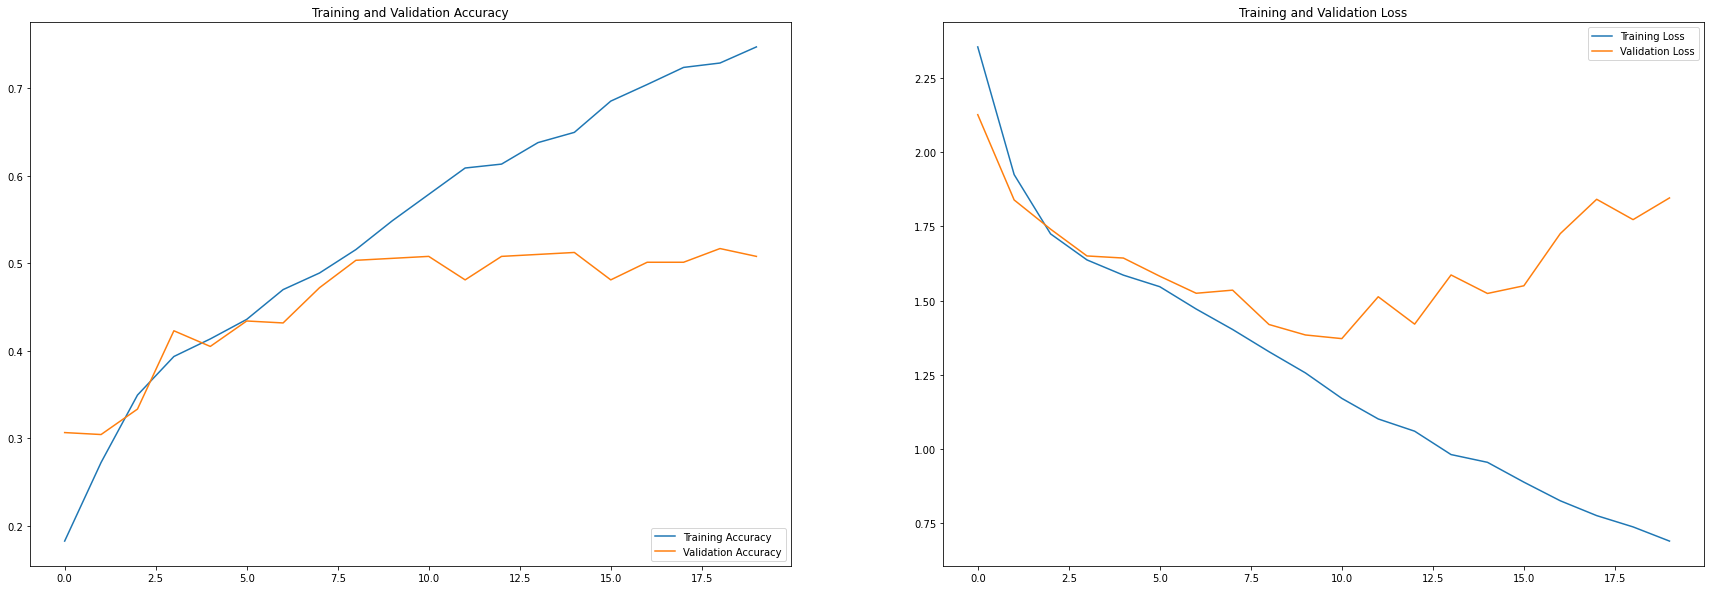

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### In the current Model, both training & validation accuracies are low.This indicates that the model is clearly underfitting!

### This can be probably to to class imbalance. It can be fixed by multiple techniques.

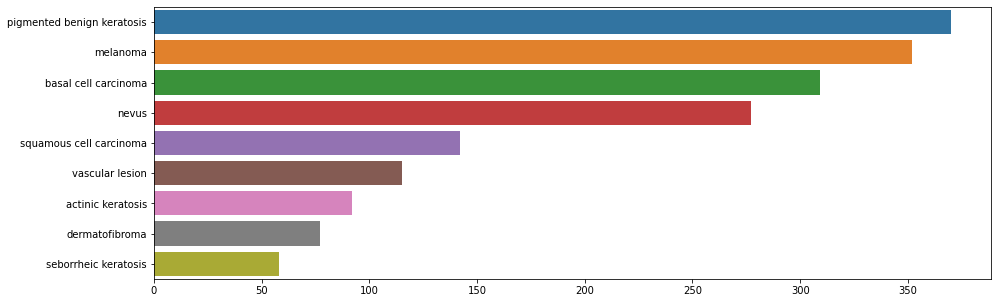

In [37]:
## Lets look at the images over different classes 
import seaborn as sns
import matplotlib.pyplot as plt

l=[]
for image, label in train_ds:
    for i in label:
        l.append(class_names[i.numpy()])
l = pd.Series(l)
num_classes = l.value_counts()

plt.figure(figsize=[15,5])
sns.barplot(x=num_classes.values, y=num_classes.index)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
##### Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##### Pigmented benign kertosis, Melanoma, Basal cell carcinoma & Nevus

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F47E077DA10>: 100%|██████████| 500/500 [00:20<00:00, 24.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F476A050550>: 100%|██████████| 500/500 [00:21<00:00, 22.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F476A5257D0>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F47E03B1A10>: 100%|██████████| 500/500 [01:34<00:00,  5.30 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F476A0D5890>: 100%|██████████| 500/500 [01:22<00:00,  6.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F47E07D6E10>: 100%|██████████| 500/500 [00:18<00:00, 27.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F47E07CD750>: 100%|██████████| 500/500 [00:40<00:00, 12.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F47E05A4F50>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F47E05AD610>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_04430a60-1182-43f8-b650-1e06c399702f.jpg',
 '/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_28d7cad7-436a-4815-8072-02266a400bb6.jpg',
 '/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_39f29c0b-73fa-4b85-9521-76ac95c044e6.jpg',
 '/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_a2e48535-b288-46b0-a37f-c1f47e6b7057.jpg',
 '/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = df2.copy()
new_df

,Path,Label
0,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,actinic keratosis
1,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,actinic keratosis
2,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,actinic keratosis
3,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,actinic keratosis
4,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,vascular lesion
4496,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,vascular lesion
4497,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,vascular lesion
4498,/content/gdrive/MyDrive/Data_sets/Skin cancer ...,vascular lesion


In [50]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
data_dir_train="/content/gdrive/MyDrive/Data_sets/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [54]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(9))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [55]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                 

#### **Todo:**  Train your model

In [56]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 32s 178ms/step - loss: 2.2255 - accuracy: 0.1708 - val_loss: 1.8868 - val_accuracy: 0.2509
Epoch 2/30
169/169 [==============================] - 30s 174ms/step - loss: 1.7017 - accuracy: 0.3516 - val_loss: 1.5553 - val_accuracy: 0.4284
Epoch 3/30
169/169 [==============================] - 30s 173ms/step - loss: 1.4738 - accuracy: 0.4293 - val_loss: 1.5554 - val_accuracy: 0.4261
Epoch 4/30
169/169 [==============================] - 31s 175ms/step - loss: 1.3383 - accuracy: 0.4902 - val_loss: 1.3421 - val_accuracy: 0.5048
Epoch 5/30
169/169 [==============================] - 30s 174ms/step - loss: 1.2393 - accuracy: 0.5376 - val_loss: 1.2364 - val_accuracy: 0.5568
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 1.1728 - accuracy: 0.5616 - val_loss: 1.2160 - val_accuracy: 0.5679
Epoch 7/30
169/169 [==============================] - 31s 176ms/step - loss: 1.0743 - accuracy: 0.5989 - val_loss: 1.1233 - val_ac

#### **Todo:**  Visualize the model results

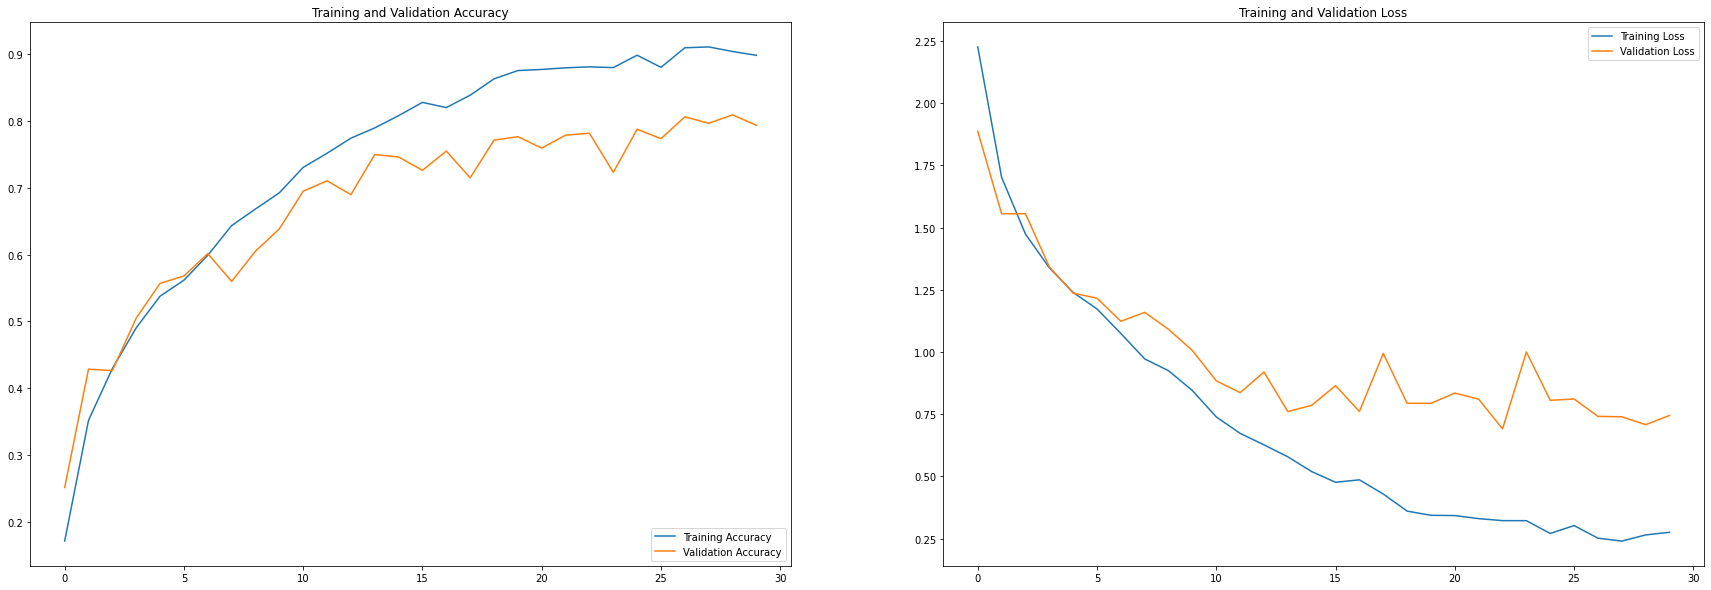

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Yes, balancing the classes helped us to overcome underfitting/overfitting problem in the model. 

- The new training accuracy is roughly 90% & the validation accuracy reached 80%.

- Batch normalisation and many other further improvisation can also be done to improve the overall model predictions 

- Also using the concept of Transfer Learning can be quiet benefecial.